<a href="https://colab.research.google.com/github/BrainConnection/QuTiP/blob/main/Project%20Dynamic%20Decoupling/meas%20induced%20dephasing%20qutip%20sim%20v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dispersive Readout of Superconducting Qubits


In [ ]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Basic parameters
N = 200 # dimension of Hilbert space (cavity)

chi = 2 * np.pi * 0.1 # in units of MHz
tau = 1.0 # in units of us
tlist = np.linspace(0, tau, 100)

alpha = 5.0 # amplitude of coherent state

psi_g = basis(2, 0)
psi_e = basis(2, 1)
psi_p = (psi_g + psi_e) / np.sqrt(2)

psi0 = tensor(psi_p, coherent(N, alpha))

a = tensor(qeye(2), destroy(N))
sm = tensor(destroy(2), qeye(N))


The dispersive Hamiltonian is given by
$$
\hat{H}_\mathrm{disp} = \chi \hat{a}^\dagger\hat{a} (|e\rangle\langle e| - |g\rangle\langle g|)
$$

In [ ]:
# Hamiltonian
H = chi * a.dag() * a * (sm.dag() * sm - sm * sm.dag())

## Time Evolution

In [ ]:
alpha = 1.0

g_alpha = tensor(psi_g, coherent(N, alpha)) # |g>⊗|α>
e_alpha = tensor(psi_e, coherent(N, alpha)) # |e>⊗|α>

# time evolution (no collapse operator)
result_g = mesolve(H, g_alpha, tlist)
result_e = mesolve(H, e_alpha, tlist)

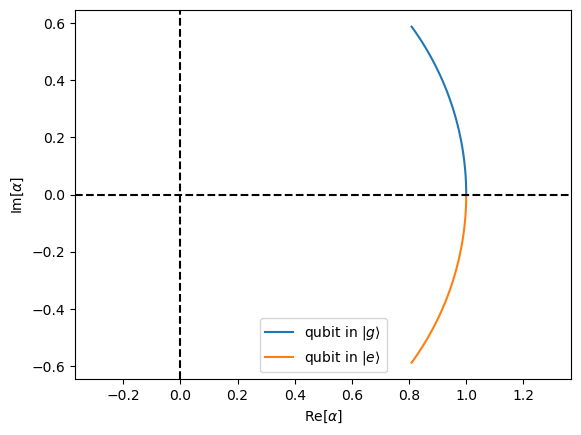

In [ ]:
plt.figure()
alpha_g = expect(a, result_g.states)
alpha_e = expect(a, result_e.states)
plt.plot(alpha_g.real, alpha_g.imag, label=r'qubit in $|g\rangle$')
plt.plot(alpha_e.real, alpha_e.imag, label=r'qubit in $|e\rangle$')
plt.xlabel(r'Re[$\alpha$]')
plt.ylabel(r'Im[$\alpha$]')
plt.axis('equal')
plt.axvline(0.0, color='black', ls='--')
plt.axhline(0.0, color='black', ls='--')
plt.legend()

Following the dispersive Hamiltonian, the qubit-state-dependent time-evolution of coherent state follows $|\alpha e^{\pm i\chi t}\rangle$. That is, if the qubit is initialized in a superposition state, the qubit-resonator system becomes *entangled* after time evolution.

Let us assume that the qubit is initialized in a superposition of the ground state and the excited state and the resonator is in a coherent state,
$$
\frac{|g\rangle + |e\rangle}{\sqrt{2}} \otimes |\alpha\rangle.
$$
After time-evolution, the final state of the system becomes
$$
|\psi(t)\rangle = \frac{|g\rangle|\alpha e^{i\chi t}\rangle + |e\rangle |\alpha e^{-i\chi t}\rangle}{\sqrt{2}}.
$$
Taking the partial trace of the full density matrix $|\psi(t)\rangle\langle\psi(t)|$ over the resonator subspace, we get the reduced density matrix in the qubit subspace:
\begin{align*}
\rho(t) &= \mathrm{Tr}_{R}[|\psi(t)\rangle\langle\psi(t)|] = \sum_{n} \langle n| \psi(t)\rangle\langle\psi(t)|n\rangle \\
&= \frac{1}{2}\left(|g\rangle\langle g| + |e\rangle\langle g| \langle \alpha e^{i\chi t}| \alpha e^{-i\chi t}\rangle + |g\rangle\langle e| \langle \alpha e^{-i\chi t}| \alpha e^{i\chi t}\rangle + |e\rangle\langle e| \right).
\end{align*}
Here, $|n\rangle$ represents the photon number state (Fock state) of the resonator. Therefore, the off-diagonal elements of the density matrix is given by
$$
\rho_{eg}(t) = \frac{1}{2} \langle \alpha e^{-i\chi t}| \alpha e^{i\chi t}\rangle = \frac{1}{2} e^{i|\alpha|^2 \sin{(2\chi t)}} e^{-2|\alpha\sin{(\chi t)}|^2},
$$
where the relation $\langle \beta | \alpha \rangle = \exp{\left[\frac{1}{2}(\beta^*\alpha - \beta \alpha^*)\right]}\exp{\left[-\frac{1}{2}|\beta - \alpha|^2\right]}$ is used [see Eq. (3.61) of Gerry and Knight, Introductory Quantum Optics (2005)].
Basically, the decoherence of qubit is determined by the distiguishability of the "macroscopic" resonator states $|\alpha e^{\pm i\chi t}\rangle$ associated with internal states of the qubit. The dephasing (decay of off-diagonal matrix element) in the small angle limit $\chi t \ll 1$  follows:
$$
|\rho_{eg}(t)| \approx \frac{1}{2} e^{-2 \bar{n} \chi^2 t^2},
$$
where $\bar{n} = |\alpha|^2$ is the mean photon number in the resonator.

## Measurement-Induced Dephasing

As discussed above, dephasing induced by the measurement process falls off exponentially with intra-cavity photon number $\bar{n} = |\alpha|^2$, which is shown in Figure 1(d) of [C. C. Bultink et al., Appl. Phys. Lett. **112**, 092601 (2018)](https://doi.org/10.1063/1.5015954). This can be reproduced by the following numerical simulations.

In [ ]:
def final_rho01_vs_alpha(alpha):

    psi0 = tensor(psi_p, coherent(N, alpha))
    result = mesolve(H, psi0, tlist)

    # extract the final state after time evolution, then take the partial trace
    rho_reduced = result.states[-1].ptrace(0)

    return np.abs(rho_reduced[0, 1])

In [ ]:
M = 100 # number of points to evaluate

coherence_list = np.zeros(M)
alpha_list = np.linspace(0, 5, M)
for i, alpha in enumerate(alpha_list):
    coherence_list[i] = final_rho01_vs_alpha(alpha)

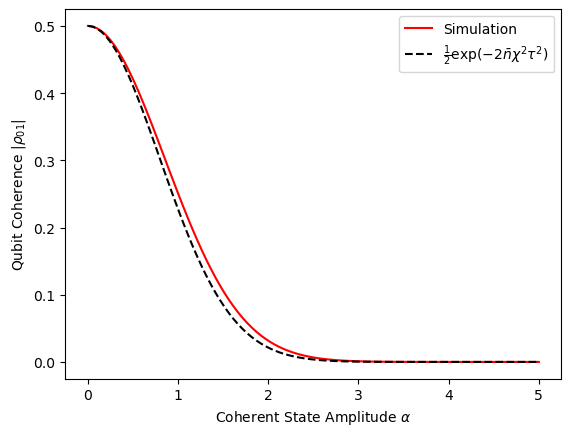

In [ ]:
plt.plot(alpha_list, coherence_list, color='red', ls='-', label='Simulation')
plt.plot(alpha_list, 0.5 * np.exp(- 2 * chi ** 2 * alpha_list ** 2 * tau ** 2), color='black', ls='--',
        label=r'$\frac{1}{2}\exp(-2\bar{n}\chi^2\tau^2)$')
plt.xlabel(r'Coherent State Amplitude $\alpha$')
plt.ylabel(r'Qubit Coherence $|\rho_{01}|$')
plt.legend()

The Gaussian shape of qubit coherence $|\rho_{eg}|$ plotted against the coherent state amplitude $\alpha$ is a typical method for characterizing the measurement-induced dephasing.

Note: The theory curve for measurement-induced dephasing of a qubit in the large-$\bar{n}$ limit is given by Eq (5.11) of [J. Gambetta et al., PRA **74**, 042318 (2006)](http://dx.doi.org/10.1103/PhysRevA.74.042318). This is of the same form as the equation derived above.